In [4]:
# =========================================================
# 0. IMPORT LIBRARIES
# =========================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# =========================================================
# 1. LOAD DATA
# =========================================================
df = pd.read_csv("/kaggle/input/medicaltranscriptions/mtsamples.csv")
df.head()



,Unnamed: 0,description,medical_specialty,sample_name,transcription,keywords
0,0,A 23-year-old white female presents with comp...,Allergy / Immunology,Allergic Rhinitis,"SUBJECTIVE:, This 23-year-old white female pr...","allergy / immunology, allergic rhinitis, aller..."
1,1,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 2,"PAST MEDICAL HISTORY:, He has difficulty climb...","bariatrics, laparoscopic gastric bypass, weigh..."
2,2,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 1,"HISTORY OF PRESENT ILLNESS: , I have seen ABC ...","bariatrics, laparoscopic gastric bypass, heart..."
3,3,2-D M-Mode. Doppler.,Cardiovascular / Pulmonary,2-D Echocardiogram - 1,"2-D M-MODE: , ,1. Left atrial enlargement wit...","cardiovascular / pulmonary, 2-d m-mode, dopple..."
4,4,2-D Echocardiogram,Cardiovascular / Pulmonary,2-D Echocardiogram - 2,1. The left ventricular cavity size and wall ...,"cardiovascular / pulmonary, 2-d, doppler, echo..."


Preview the dataset after loading it, so you can check: 
- Column names
- Data types
- Whether the file was read correctly
- Any obvious missing or strange values

In [10]:
df.info()
df.isna().sum()

df = df.dropna(subset=["medical_specialty", "transcription"])
df.shape


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4999 entries, 0 to 4998
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Unnamed: 0         4999 non-null   int64 
 1   description        4999 non-null   object
 2   medical_specialty  4999 non-null   object
 3   sample_name        4999 non-null   object
 4   transcription      4966 non-null   object
 5   keywords           3931 non-null   object
dtypes: int64(1), object(5)
memory usage: 234.5+ KB


(4966, 6)

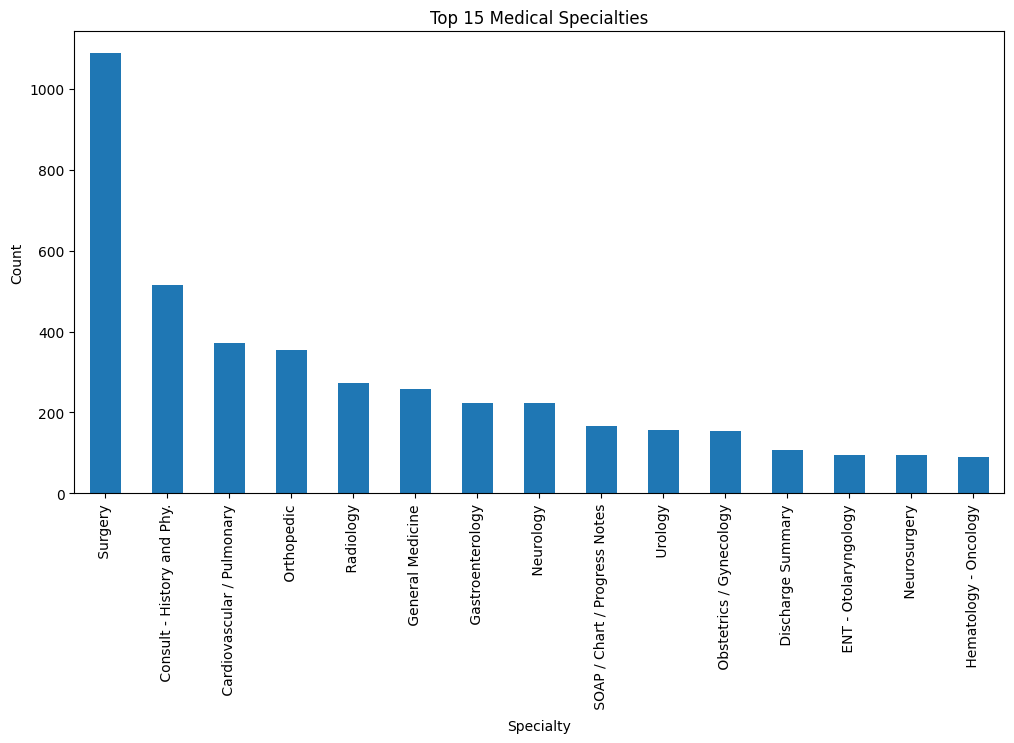

In [11]:
plt.figure(figsize=(12,6))
df['medical_specialty'].value_counts().head(15).plot(kind='bar')
plt.title("Top 15 Medical Specialties")
plt.xlabel("Specialty")
plt.ylabel("Count")
plt.show()


This code visualizes the top 15 medical specialties in the dataset as a bar chart.


In [12]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"\n", " ", text)
    text = re.sub(r"[0-9]", " ", text)
    text = text.translate(str.maketrans("", "", string.punctuation))
    text = re.sub(r"\s+", " ", text).strip()
    return text

df["clean_text"] = df["transcription"].apply(clean_text)
df["clean_text"].head()


0    subjective this yearold white female presents ...
1    past medical history he has difficulty climbin...
2    history of present illness i have seen abc tod...
3    d mmode left atrial enlargement with left atri...
4    the left ventricular cavity size and wall thic...
Name: clean_text, dtype: object

Clean and preprocess the text data in the transcription column of your dataset


In [13]:
X = df["clean_text"]
y = df["medical_specialty"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train.shape, X_test.shape


((3972,), (994,))

**Separate the dataset into training and testing subsets** so you can train your model on one portion and evaluate it on unseen data. 


In [15]:
vectorizer = TfidfVectorizer(stop_words='english', max_features=50000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)


To convert raw text into numerical vectors that can be used by machine learning models

In [16]:
model = LogisticRegression(max_iter=500)
model.fit(X_train_tfidf, y_train)


LogisticRegression(max_iter=500)

To **train a classification model** that can predict the medical specialty of a transcription based on its text.


In [17]:
y_pred = model.predict(X_test_tfidf)
print("Accuracy:", accuracy_score(y_test, y_pred))


Accuracy: 0.23742454728370221


This code’s target is ****evaluating the model’s predictive accuracy on the test set****


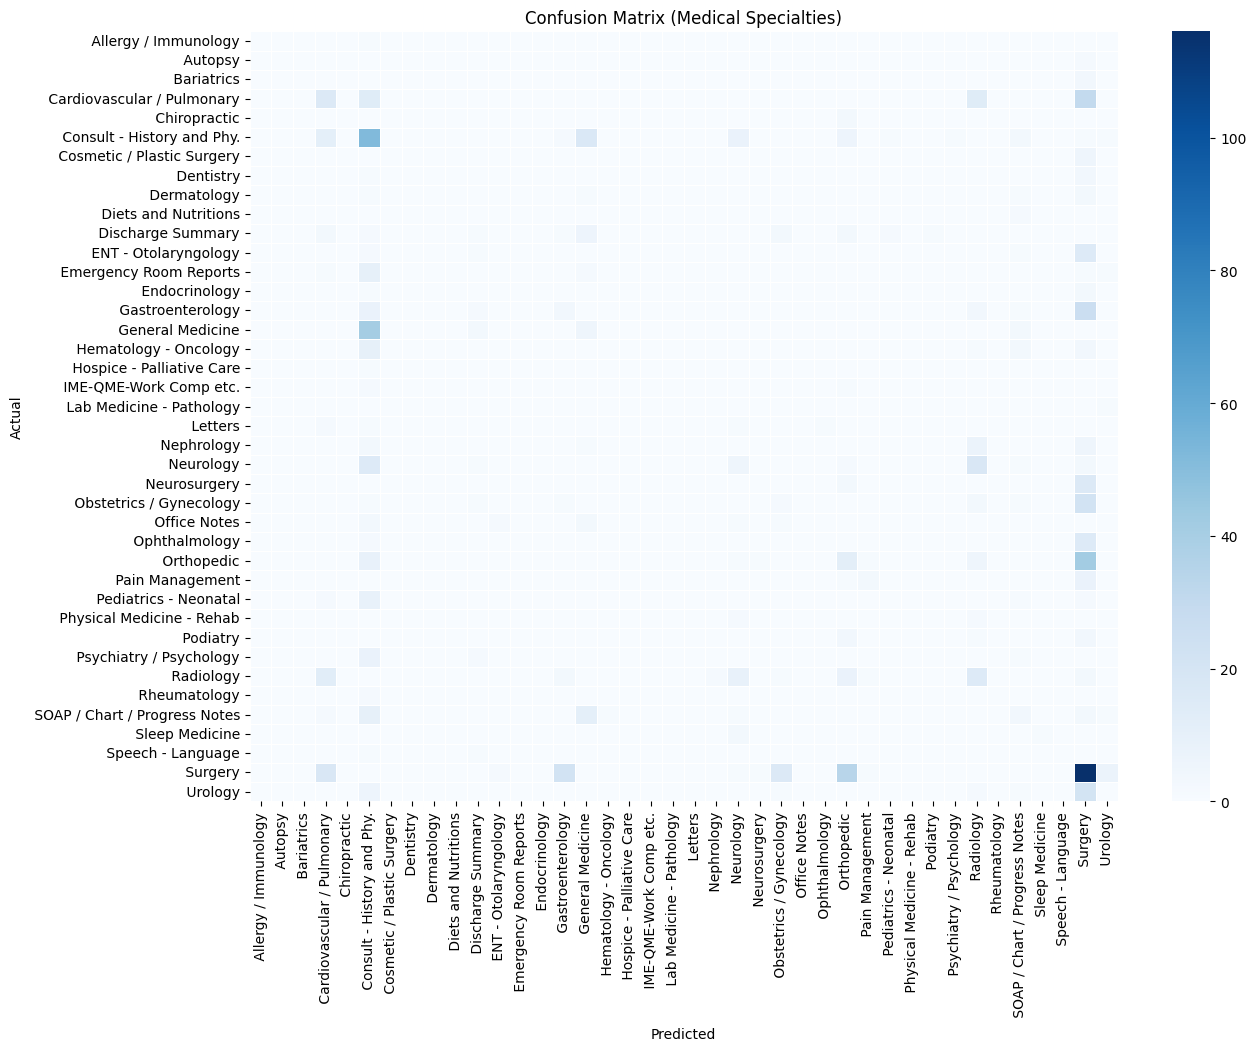

In [19]:
plt.figure(figsize=(14,10))
cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm,
            cmap="Blues",
            xticklabels=model.classes_,
            yticklabels=model.classes_,
            linewidths=.5)

plt.title("Confusion Matrix (Medical Specialties)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


****To plot a heatmap of the confusion matrix, showing how well the model classifies medical specialties.****


In [20]:
def predict_specialty(text):
    text = clean_text(text)
    vector = vectorizer.transform([text])
    return model.predict(vector)[0]

sample = """
The patient shows signs of chronic obstructive pulmonary disease.
Recommend bronchodilators and schedule spirometry testing.
"""

print("Prediction:", predict_specialty(sample))


Prediction:  Cardiovascular / Pulmonary


To create a ****reusable function**** that takes any new medical transcription text and outputs the predicted ****medical specialty****.
